In [323]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from pathlib import Path
import os
import re
import pandas as pd

from tqdm import tqdm
import time

from mgcpy.independence_tests.mgc import MGC

from itertools import combinations

np.set_printoptions(precision=5)
pd.set_option("display.precision", 5)

In [328]:
h5_key = 'latent'
## Define paths
basedir = Path('..') 
datadir = basedir / 'data'
rawdir = datadir / 'raw'
gccadir = datadir / 'interim' / 'gcca250'

In [284]:
tasks = ['restingstate', 'openmonitoring', 'compassion']
levels = ['e', 'n']

In [177]:
def get_files(path,
              level='(e|n)',
              subject='([0-9]{3})',
              task='(.+?)',
              filetype='h5',
              flag=''):
    files = []
    query = f'^{level}_sub-'
    query += f'{subject}_ses-1_'
    query += f'task-{task}{flag}.{filetype}'
    for f in os.listdir(path):
        match = re.search(query, f)
        if match:
            files.append((f, match.groups()))
    
    return(files)

In [179]:
lookup = {'(e|n)':'All',
          '(.+?)':'All',
          'e':'Experts',
          'n':'Novices',
          'openmonitoring':'Open Monitoring',
          'compassion':'Compassion',
          'restingstate':'Resting',
          '(openmonitoring|compassion)': 'Meditating'}

In [222]:
## Get class files
def get_class(components,level,task,cls_num=1):
    paths = get_files(path=gccadir, level=level, task=task, flag='_gcca')

    latents = []
    labels = []
    for path,_ in tqdm(paths):
        h5f = h5py.File(gccadir / path,'r')
        if components is not None:
            latent = h5f[h5_key][:][:,components]
        else:
            latent = h5f[h5_key][:]
        h5f.close()
        latents.append(latent.reshape(1, -1))
        labels.append(f'{cls_num}')

    return(np.vstack(latents), labels)

In [169]:
def transform_matrices(x, y, is_y_categorical=False):
    if not is_y_categorical:
        u = np.concatenate([x, y], axis=0)
        v = np.concatenate([np.repeat(1, x.shape[0]), np.repeat(2, y.shape[0])], axis=0)
    else:
        u = x
        v = preprocessing.LabelEncoder().fit_transform(y) + 1
    
    if len(u.shape) == 1:
        u = u[..., np.newaxis]
    if len(v.shape) == 1:
        v = v[..., np.newaxis]
    
    return(u, v)

In [326]:
def discrim_test(trait1,state1,trait2,state2,components):
    latents1, _ = get_class(components=components,cls_num=1,level=trait1,task=state1)
    latents2, _ = get_class(components=components,cls_num=2,level=trait2,task=state2)
    
    u,v = transform_matrices(latents1,latents2)
    
    mgc = MGC()
    pval, _ = mgc.p_value(u,v, is_fast=False, replication_factor=1000)
    
    name = f'{lookup[trait1]} {lookup[state1]} vs. {lookup[trait2]} {lookup[state2]}'
    
    return(pval, name)

In [330]:
data_dict = {}

In [331]:
n_components = [0]
pvals = []
names = []

## x vs. x
states = ['restingstate', 'openmonitoring', 'compassion']
traits = ['e', 'n', '(e|n)']

for trait in traits:
    for state1,state2 in combinations(states,2):
        pval,name = discrim_test(trait,state1,trait,state2,n_components)
        pvals.append(pval)
        names.append(name)
        print(name)
        
    state1, state2 = '(openmonitoring|compassion)', 'restingstate'
    pval,name = discrim_test(trait,state1,trait,state2,n_components)
    pvals.append(pval)
    names.append(name)
    print(name)

## x vs. y
trait1 = 'e'
trait2 = 'n'

## Inter (between) states
for state1,state2 in combinations(states,2):
    pval,name = discrim_test(trait1,state1,trait2,state2,n_components)
    pvals.append(pval)
    names.append(name)
    print(name)
    pval,name = discrim_test(trait1,state2,trait2,state1,n_components)
    pvals.append(pval)
    names.append(name)
    print(name)
    
## Intra (within) state
for state in states + ['(.+?)']:
    pval,name = discrim_test(trait1,state,trait2,state,n_components)
    pvals.append(pval)
    names.append(name)
    print(name)
    
state1, state2 = '(openmonitoring|compassion)', 'restingstate'
pval,name = discrim_test(trait1,state1,trait2,state2,n_components)
pvals.append(pval)
names.append(name)
print(name)

data_dict[str(n_components)] = (names,pvals)

100%|██████████| 29/29 [00:00<00:00, 84.44it/s]
/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/mgcpy/independence_tests/abstract_class.py:153: UserWarning: The p-value is greater than 0.05, implying that the results are not statistically significant.
Use results such as test_statistic and optimal_scale, with caution!
  warnings.warn("The p-value is greater than 0.05, implying that the results are not statistically significant.\n" +
 28%|██▊       | 8/29 [00:00<00:00, 73.78it/s]

Experts Resting vs. Experts Open Monitoring


100%|██████████| 29/29 [00:00<00:00, 64.07it/s]
/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/mgcpy/independence_tests/abstract_class.py:153: UserWarning: The p-value is greater than 0.05, implying that the results are not statistically significant.
Use results such as test_statistic and optimal_scale, with caution!
  warnings.warn("The p-value is greater than 0.05, implying that the results are not statistically significant.\n" +
100%|██████████| 29/29 [00:00<00:00, 324.84it/s]


Experts Resting vs. Experts Compassion


/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/mgcpy/independence_tests/abstract_class.py:153: UserWarning: The p-value is greater than 0.05, implying that the results are not statistically significant.
Use results such as test_statistic and optimal_scale, with caution!
  warnings.warn("The p-value is greater than 0.05, implying that the results are not statistically significant.\n" +
 57%|█████▋    | 33/58 [00:00<00:00, 327.24it/s]

Experts Open Monitoring vs. Experts Compassion


100%|██████████| 29/29 [00:00<00:00, 194.64it/s]
/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/mgcpy/independence_tests/abstract_class.py:153: UserWarning: The p-value is greater than 0.05, implying that the results are not statistically significant.
Use results such as test_statistic and optimal_scale, with caution!
  warnings.warn("The p-value is greater than 0.05, implying that the results are not statistically significant.\n" +
 13%|█▎        | 6/47 [00:00<00:00, 52.89it/s]

Experts Meditating vs. Experts Resting


100%|██████████| 47/47 [00:00<00:00, 51.80it/s]
/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/mgcpy/independence_tests/abstract_class.py:153: UserWarning: The p-value is greater than 0.05, implying that the results are not statistically significant.
Use results such as test_statistic and optimal_scale, with caution!
  warnings.warn("The p-value is greater than 0.05, implying that the results are not statistically significant.\n" +
  0%|          | 0/47 [00:00<?, ?it/s]

Novices Resting vs. Novices Open Monitoring


100%|██████████| 47/47 [00:00<00:00, 93.18it/s]
/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/mgcpy/independence_tests/abstract_class.py:153: UserWarning: The p-value is greater than 0.05, implying that the results are not statistically significant.
Use results such as test_statistic and optimal_scale, with caution!
  warnings.warn("The p-value is greater than 0.05, implying that the results are not statistically significant.\n" +
  0%|          | 0/47 [00:00<?, ?it/s]

Novices Resting vs. Novices Compassion


100%|██████████| 47/47 [00:00<00:00, 511.47it/s]
/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/mgcpy/independence_tests/abstract_class.py:153: UserWarning: The p-value is greater than 0.05, implying that the results are not statistically significant.
Use results such as test_statistic and optimal_scale, with caution!
  warnings.warn("The p-value is greater than 0.05, implying that the results are not statistically significant.\n" +
 46%|████▌     | 43/94 [00:00<00:00, 421.67it/s]

Novices Open Monitoring vs. Novices Compassion


100%|██████████| 47/47 [00:00<00:00, 617.48it/s]
/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/mgcpy/independence_tests/abstract_class.py:153: UserWarning: The p-value is greater than 0.05, implying that the results are not statistically significant.
Use results such as test_statistic and optimal_scale, with caution!
  warnings.warn("The p-value is greater than 0.05, implying that the results are not statistically significant.\n" +
  0%|          | 0/76 [00:00<?, ?it/s]

Novices Meditating vs. Novices Resting


100%|██████████| 76/76 [00:00<00:00, 521.75it/s]
/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/mgcpy/independence_tests/abstract_class.py:153: UserWarning: The p-value is greater than 0.05, implying that the results are not statistically significant.
Use results such as test_statistic and optimal_scale, with caution!
  warnings.warn("The p-value is greater than 0.05, implying that the results are not statistically significant.\n" +
  0%|          | 0/76 [00:00<?, ?it/s]

All Resting vs. All Open Monitoring


100%|██████████| 76/76 [00:00<00:00, 399.37it/s]
/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/mgcpy/independence_tests/abstract_class.py:153: UserWarning: The p-value is greater than 0.05, implying that the results are not statistically significant.
Use results such as test_statistic and optimal_scale, with caution!
  warnings.warn("The p-value is greater than 0.05, implying that the results are not statistically significant.\n" +
  8%|▊         | 6/76 [00:00<00:01, 54.40it/s]

All Resting vs. All Compassion


100%|██████████| 76/76 [00:01<00:00, 61.81it/s]
/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/mgcpy/independence_tests/abstract_class.py:153: UserWarning: The p-value is greater than 0.05, implying that the results are not statistically significant.
Use results such as test_statistic and optimal_scale, with caution!
  warnings.warn("The p-value is greater than 0.05, implying that the results are not statistically significant.\n" +
 27%|██▋       | 41/152 [00:00<00:00, 409.86it/s]

All Open Monitoring vs. All Compassion


100%|██████████| 76/76 [00:00<00:00, 80.22it/s]
/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/mgcpy/independence_tests/abstract_class.py:153: UserWarning: The p-value is greater than 0.05, implying that the results are not statistically significant.
Use results such as test_statistic and optimal_scale, with caution!
  warnings.warn("The p-value is greater than 0.05, implying that the results are not statistically significant.\n" +
 14%|█▍        | 4/29 [00:00<00:00, 38.66it/s]

All Meditating vs. All Resting


  0%|          | 0/47 [00:00<?, ?it/s]

Experts Resting vs. Novices Open Monitoring


100%|██████████| 47/47 [00:00<00:00, 141.23it/s]
/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/mgcpy/independence_tests/abstract_class.py:153: UserWarning: The p-value is greater than 0.05, implying that the results are not statistically significant.
Use results such as test_statistic and optimal_scale, with caution!
  warnings.warn("The p-value is greater than 0.05, implying that the results are not statistically significant.\n" +
  0%|          | 0/47 [00:00<?, ?it/s]

Experts Open Monitoring vs. Novices Resting


100%|██████████| 47/47 [00:00<00:00, 251.24it/s]
/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/mgcpy/independence_tests/abstract_class.py:153: UserWarning: The p-value is greater than 0.05, implying that the results are not statistically significant.
Use results such as test_statistic and optimal_scale, with caution!
  warnings.warn("The p-value is greater than 0.05, implying that the results are not statistically significant.\n" +
 90%|████████▉ | 26/29 [00:00<00:00, 128.09it/s]

Experts Resting vs. Novices Compassion


100%|██████████| 47/47 [00:00<00:00, 286.30it/s]
/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/mgcpy/independence_tests/abstract_class.py:153: UserWarning: The p-value is greater than 0.05, implying that the results are not statistically significant.
Use results such as test_statistic and optimal_scale, with caution!
  warnings.warn("The p-value is greater than 0.05, implying that the results are not statistically significant.\n" +
 26%|██▌       | 12/47 [00:00<00:00, 117.65it/s]

Experts Compassion vs. Novices Resting


100%|██████████| 47/47 [00:00<00:00, 186.94it/s]
/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/mgcpy/independence_tests/abstract_class.py:153: UserWarning: The p-value is greater than 0.05, implying that the results are not statistically significant.
Use results such as test_statistic and optimal_scale, with caution!
  warnings.warn("The p-value is greater than 0.05, implying that the results are not statistically significant.\n" +
100%|██████████| 47/47 [00:00<00:00, 380.18it/s]


Experts Open Monitoring vs. Novices Compassion


/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/mgcpy/independence_tests/abstract_class.py:153: UserWarning: The p-value is greater than 0.05, implying that the results are not statistically significant.
Use results such as test_statistic and optimal_scale, with caution!
  warnings.warn("The p-value is greater than 0.05, implying that the results are not statistically significant.\n" +
100%|██████████| 47/47 [00:00<00:00, 409.47it/s]


Experts Compassion vs. Novices Open Monitoring


/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/mgcpy/independence_tests/abstract_class.py:153: UserWarning: The p-value is greater than 0.05, implying that the results are not statistically significant.
Use results such as test_statistic and optimal_scale, with caution!
  warnings.warn("The p-value is greater than 0.05, implying that the results are not statistically significant.\n" +
100%|██████████| 47/47 [00:00<00:00, 423.16it/s]


Experts Resting vs. Novices Resting


/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/mgcpy/independence_tests/abstract_class.py:153: UserWarning: The p-value is greater than 0.05, implying that the results are not statistically significant.
Use results such as test_statistic and optimal_scale, with caution!
  warnings.warn("The p-value is greater than 0.05, implying that the results are not statistically significant.\n" +
 89%|████████▉ | 42/47 [00:00<00:00, 414.39it/s]

Experts Open Monitoring vs. Novices Open Monitoring


100%|██████████| 47/47 [00:00<00:00, 291.11it/s]
/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/mgcpy/independence_tests/abstract_class.py:153: UserWarning: The p-value is greater than 0.05, implying that the results are not statistically significant.
Use results such as test_statistic and optimal_scale, with caution!
  warnings.warn("The p-value is greater than 0.05, implying that the results are not statistically significant.\n" +
 38%|███▊      | 33/87 [00:00<00:00, 325.72it/s]

Experts Compassion vs. Novices Compassion


  0%|          | 0/47 [00:00<?, ?it/s]

Experts All vs. Novices All


100%|██████████| 47/47 [00:00<00:00, 414.26it/s]


Experts Meditating vs. Novices Resting


In [286]:
df=pd.DataFrame(columns=[])
for key in sorted(data_dict.keys(), reverse=True):
    names,pvals = data_dict[key]
    df['Samples Compared'] = names
    df[f'components={key}'] = [f'{x:.2g}' for x in pvals]

In [189]:
save_path = basedir / 'reports' / 'mgc_gcca_pvals.csv'
#df.to_csv(save_path, index=False)

### MGC two-sample for each component, all vs. all

In [321]:
trait1 = 'e'
trait2 = 'n'
    
n_components = None
## Intra (within) state
state1, state2 = '(openmonitoring|compassion)', 'restingstate'
#state1, state2 = '(.+?)', '(.+?)'
ncomps = list(range(3))
#pvals = {i:[] for i in ncomps}
t0=time.time()
for i in range(9):
    for ncomp in ncomps:
        pval,name = discrim_test(trait1,state1,trait2,state2,components=[ncomp])
        pvals[ncomp].append(pval)
timediff=time.time()-t0

100%|██████████| 47/47 [00:00<00:00, 122.39it/s]


KeyboardInterrupt: 

([<matplotlib.axis.XTick at 0x7f5dbae84fd0>,
 <a list of 8 Text xticklabel objects>)

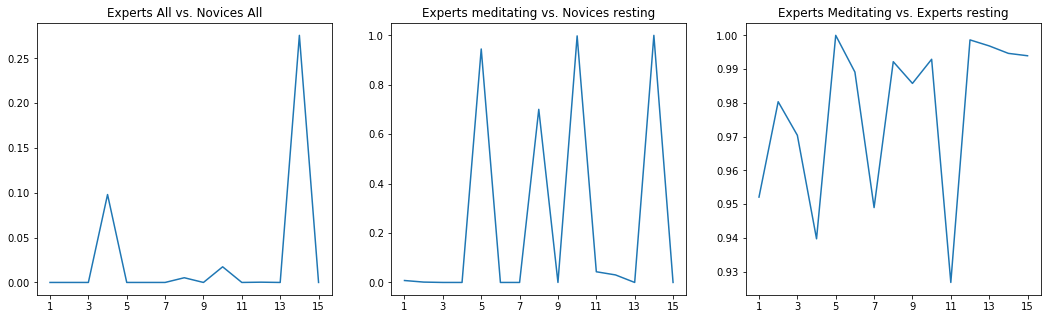

In [302]:
n = 3
plt.subplots(1,n,figsize=(18,5))
plt.subplot(1,n,1)
plt.plot(list(range(1,16)),pvals_en_all)
plt.title('Experts All vs. Novices All')
plt.xticks(range(1,16,2))

plt.subplot(1,n,2)
plt.plot(list(range(1,16)),pvals_en_med)
plt.title('Experts meditating vs. Novices resting')
plt.xticks(range(1,16,2))

plt.subplot(1,n,3)
plt.plot(list(range(1,16)),pvals_ee_med)
plt.title('Experts Meditating vs. Experts resting')
plt.xticks(range(1,16,2))

In [218]:
latents1,labels1 = get_class(n_components=None,task=state,level=trait1)

100%|██████████| 87/87 [00:00<00:00, 434.66it/s]
